[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/saulventura/CS-7641-Assignment1/blob/master/LoanEligibility.ipynb)
  
    

# Project:

Predict Loan Eligibility for Dream Housing Finance company
Dream Housing Finance company deals in all kinds of home loans. They have presence across all urban, semi urban and rural areas. Customer first applies for home loan and after that company validates the customer eligibility for loan.

Company wants to automate the loan eligibility process (real time) based on customer detail provided while filling online application form. These details are Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and others. To automate this process, they have provided a dataset to identify the customers segments that are eligible for loan amount so that they can specifically target these customers. 


# Loan Eligibility 
<img src="loan.jpg" width="100%" height="100%"/>

In [67]:
import pandas as pd
import numpy as np
import math as math
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
%matplotlib inline
from pandas.api.types import is_string_dtype
from pandas.api.types import is_numeric_dtype
from IPython.display import Markdown, display
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


import warnings
warnings.filterwarnings('ignore')

<div class="alert alert-block alert-info">
<b><h1>1. Data Collection</h1></div>
</a><a class="anchor" id="exploration"></a>

In [68]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

In [69]:
train_orig = pd.read_csv('Loandataset.csv')

In [70]:
train_orig.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [71]:
train_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [72]:
train_orig.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


<div class="alert alert-block alert-info">
<b><h1>2. Data Preparation</h1></div>
</a><a class="anchor" id="exploration"></a>

Let's assing original dataframes to new ones.

In [73]:
train = train_orig

Renaming column labels when they contain blank spaces or any special character


In [74]:
def rename_column_labels(df, old_str = " ", new_str = "_"):
    """Rename column names to avoid special characters or blank spaces.
           Parameters:
               df (dataframe): The dataframe whose columns's names will be evaluated
               old_str (str): The character from the column's names to be replaced
               new_str (str): The character that will replace 'old_str'
            Returns:
               df (dataframe): The input dataframe with the columns renamed
    """
    display(Markdown('**Results:**' ))
    cols = df.loc[:,df.columns.str.contains(old_str)].shape[1]
    if cols > 0:
        print("Features changed => {0}".format(cols))
        display(df.loc[:,df.columns.str.contains(old_str)].columns.values)
        df.columns = [label.replace(old_str, new_str ) for label in df.columns]
    else:
        print("No changes were applied")
    return df

In [75]:
train = rename_column_labels(train)

**Results:**

No changes were applied


**4.1 Remove Columns/Rows**


<strong>Let's check what columns are indexes.</strong>

In [76]:
def list_index_columns(df):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() == len(df):
            print(f"{col.ljust(25)}" +  ' ==> Datatype: ' + str(df[col].dtypes) )

In [77]:
list_index_columns(train)

**Results:**

Loan_ID                   ==> Datatype: object


<strong>Let's do a quick review of list of values per each column.</strong>


In [78]:
def list_column_values(df, number_of_values, print_all):
    display(Markdown('**Results:**' ))
    for col in df.columns[0:]:
        if df[col].nunique() <= number_of_values:
            print(f"{col.ljust(25)}" +  ' ==> ' + str(df[col].sort_values().unique().tolist()) )
        else:  
            if print_all=='True':
               print(f"{col.ljust(25)}" + ' ==> more than ' + str(number_of_values) + ' values')

In [79]:
list_column_values(train,10,'False')

**Results:**

Gender                    ==> ['Female', 'Male', nan]
Married                   ==> ['No', 'Yes', nan]
Dependents                ==> ['0', '1', '2', '3+', nan]
Education                 ==> ['Graduate', 'Not Graduate']
Self_Employed             ==> ['No', 'Yes', nan]
Loan_Amount_Term          ==> [12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0, nan]
Credit_History            ==> [0.0, 1.0, nan]
Property_Area             ==> ['Rural', 'Semiurban', 'Urban']
Loan_Status               ==> ['N', 'Y']


In [80]:
def list_column_values_percentage(df, number_of_values):
    display(Markdown('**Results:**' ))
    print('Columns with less than ' + str(number_of_values) + ' values')
    for col in df.columns[0:]:
        if train[col].nunique() <= number_of_values:
            print(df[col].value_counts()/len(train)) 

In [81]:
list_column_values_percentage(train,3)

**Results:**

Columns with less than 3 values
Male      0.796417
Female    0.182410
Name: Gender, dtype: float64
Yes    0.648208
No     0.346906
Name: Married, dtype: float64
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
No     0.814332
Yes    0.133550
Name: Self_Employed, dtype: float64
1.0    0.773616
0.0    0.144951
Name: Credit_History, dtype: float64
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64


In [82]:
def remove_column_values(df, columns_to_remove):
    display(Markdown('**Results:**'))
    print("Original number of features => {}".format(df.shape[1]))
    df = df.drop(columns_to_remove, axis=1)
    print("Number of features has been reduced to => {}".format(df.shape[1]))
    return df

** Let's remove column Loan ID **

In [83]:
train = remove_column_values(train,'Loan_ID')

**Results:**

Original number of features => 13
Number of features has been reduced to => 12


**Missing Values**

In [84]:
train.isnull().sum()

Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [85]:
np.round(100*train.isnull().sum()/ len(train),2)

Gender               2.12
Married              0.49
Dependents           2.44
Education            0.00
Self_Employed        5.21
ApplicantIncome      0.00
CoapplicantIncome    0.00
LoanAmount           3.58
Loan_Amount_Term     2.28
Credit_History       8.14
Property_Area        0.00
Loan_Status          0.00
dtype: float64

In [86]:
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        display(Markdown('**Results:**'))
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [87]:
missing_values_table(train)

**Results:**

Your selected dataframe has 12 columns.
There are 7 columns that have missing values.


,Missing Values,% of Total Values
Credit_History,50,8.1
Self_Employed,32,5.2
LoanAmount,22,3.6
Dependents,15,2.4
Loan_Amount_Term,14,2.3
Gender,13,2.1
Married,3,0.5


<AxesSubplot:>

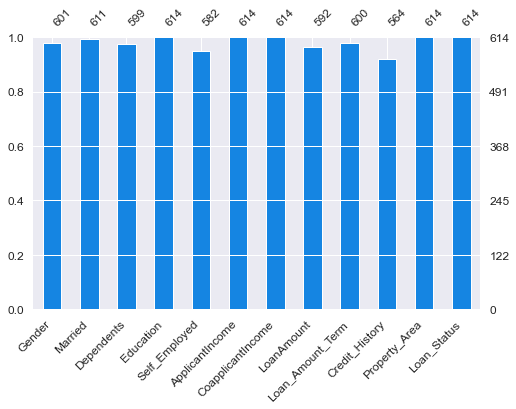

In [88]:
msno.bar(train, color = '#1585E2',fontsize=12,figsize = (8, 5))

<AxesSubplot:>

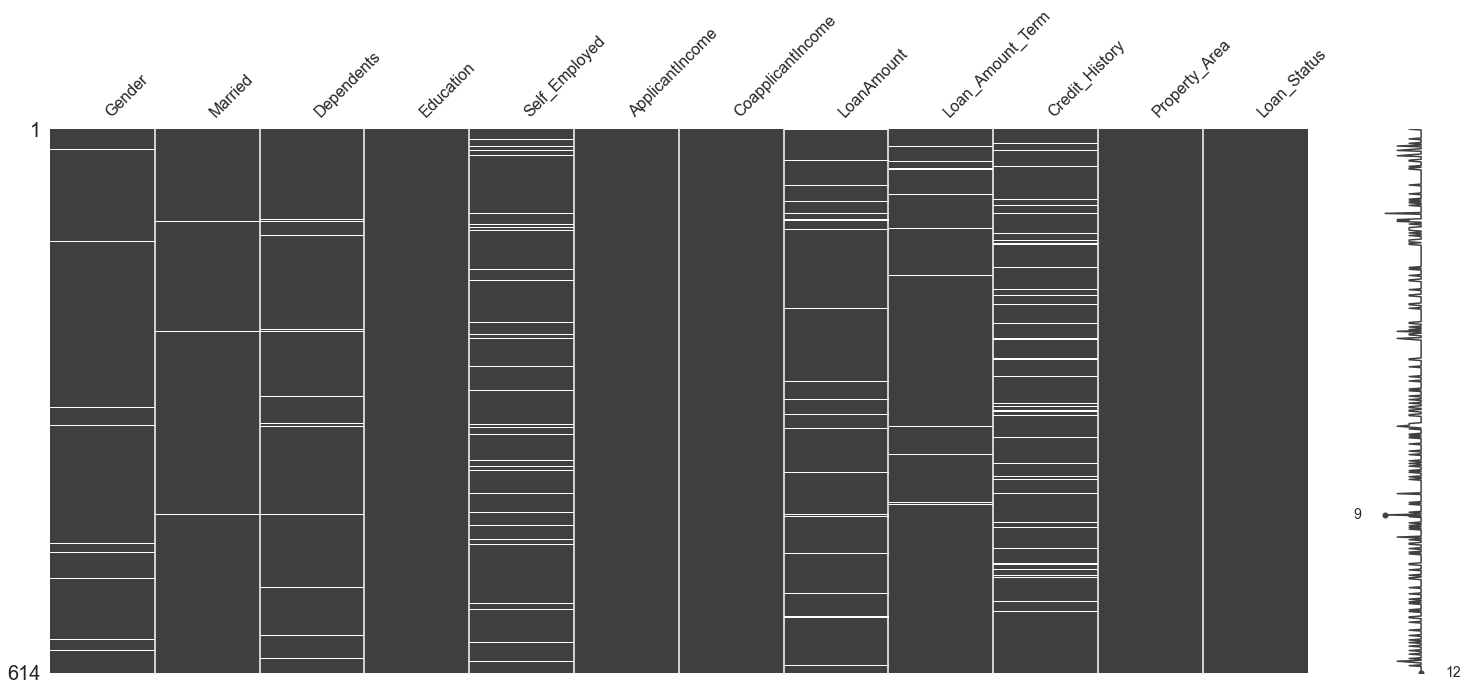

In [89]:
msno.matrix(train)


<AxesSubplot:>

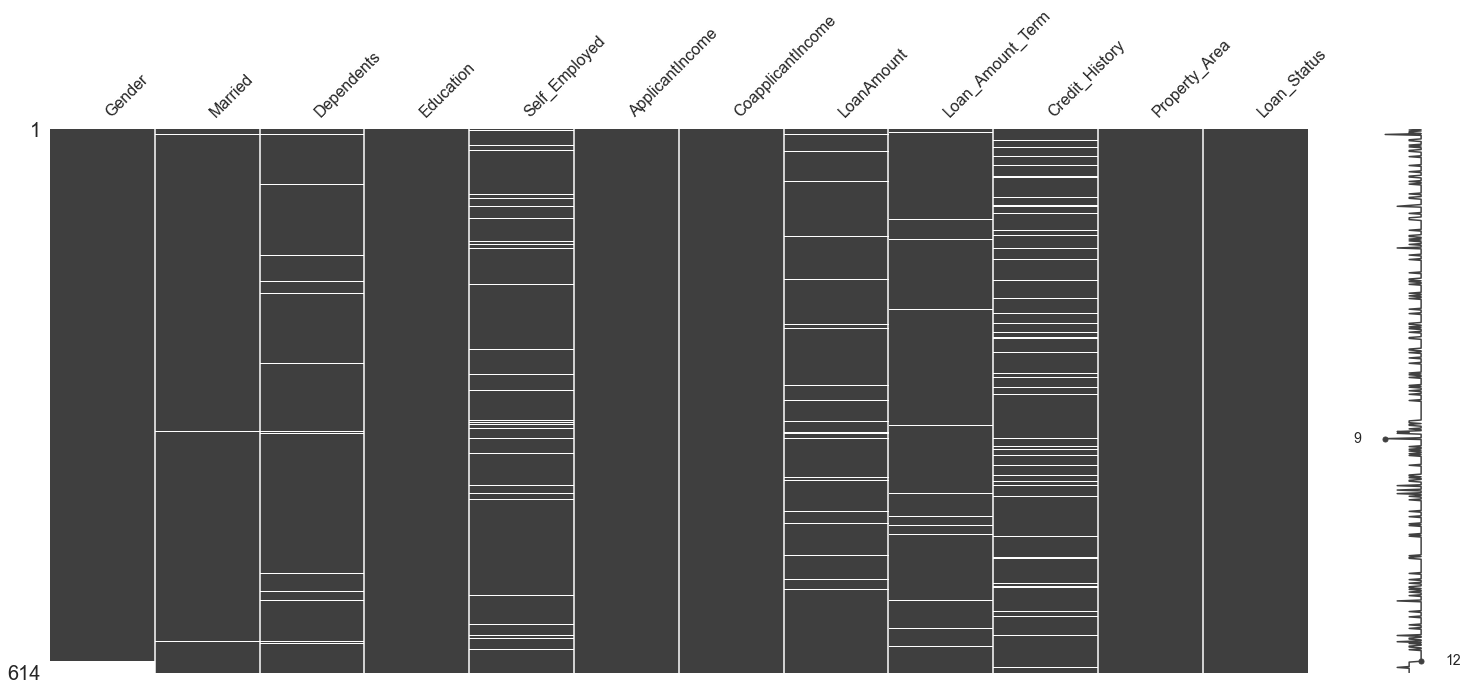

In [90]:
#sorted by gender
sorted = train.sort_values('Gender')
msno.matrix(sorted)

<AxesSubplot:>

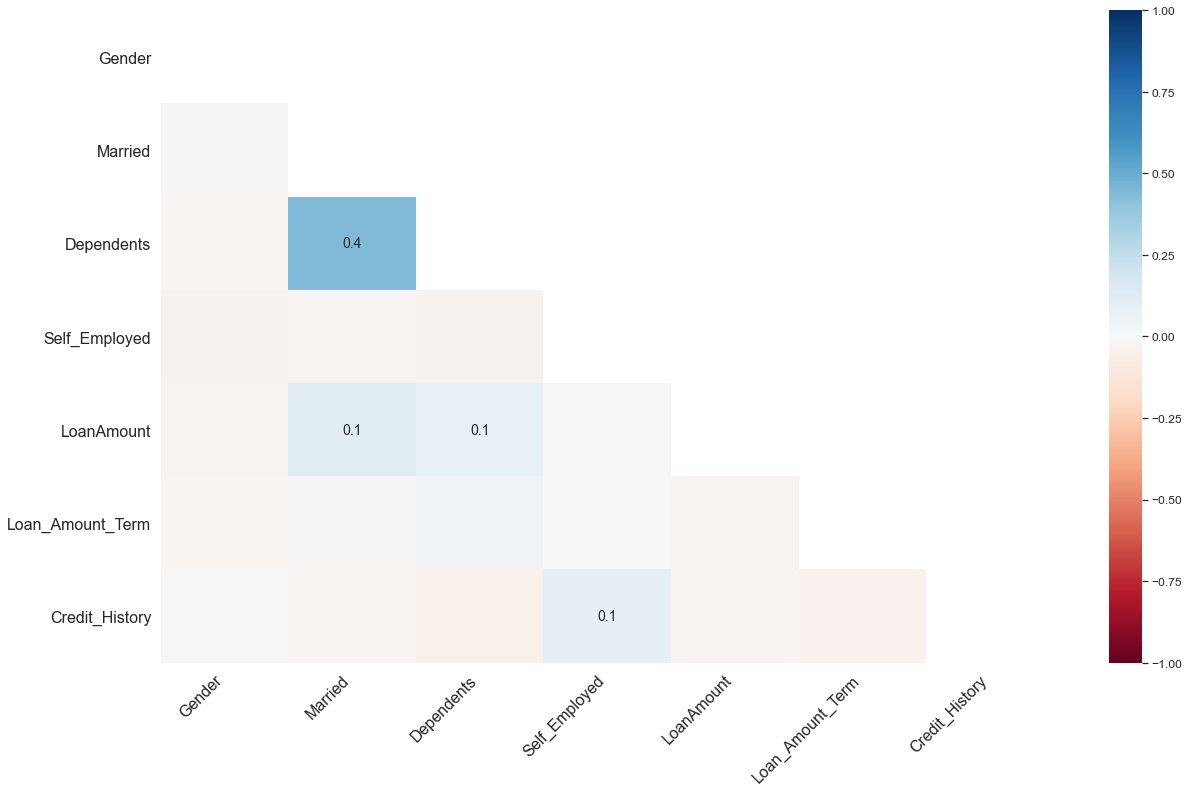

In [91]:
msno.heatmap(train)

<AxesSubplot:>

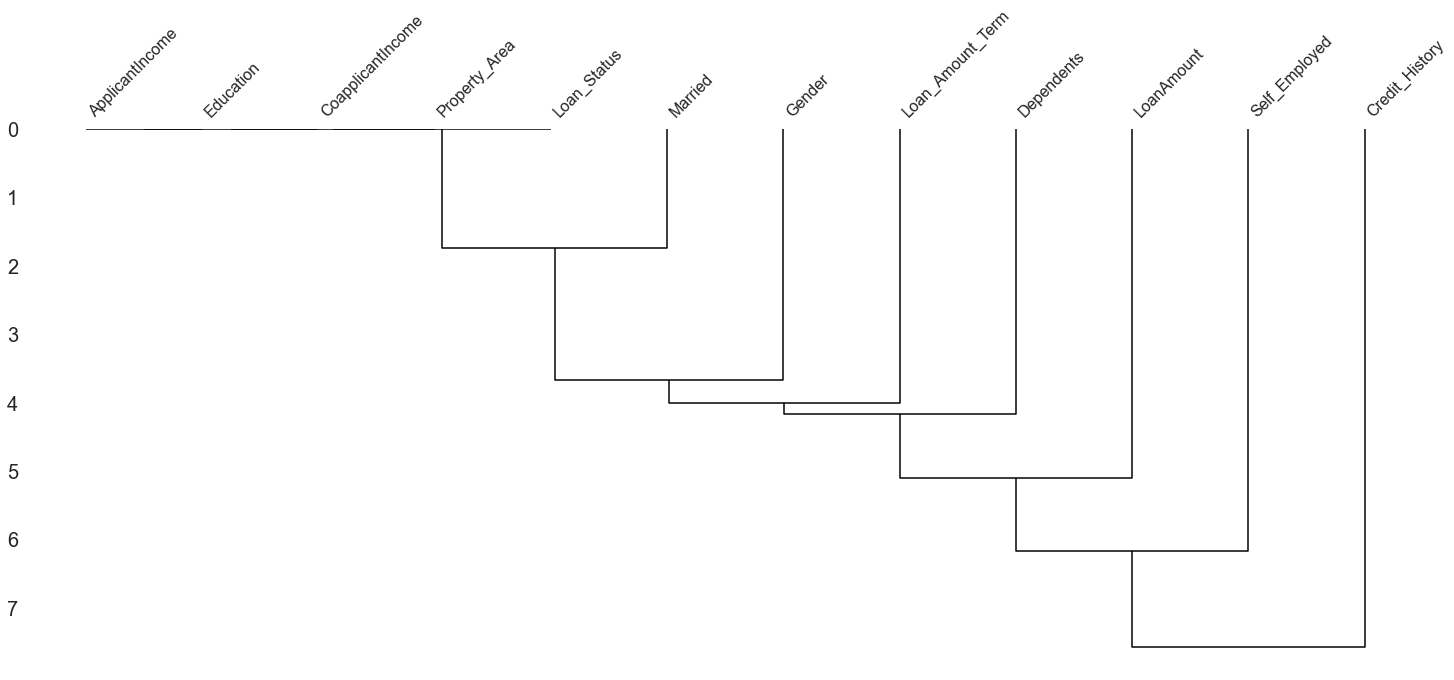

In [92]:
msno.dendrogram(train)

**Let's remove selected columns/rows with missing values.**

** Since there is no clear understanding/portion of missing columns, I don't plan to drop any columns from the list ** 

### Imputation

### New imputation technique: using regression model


<AxesSubplot:>

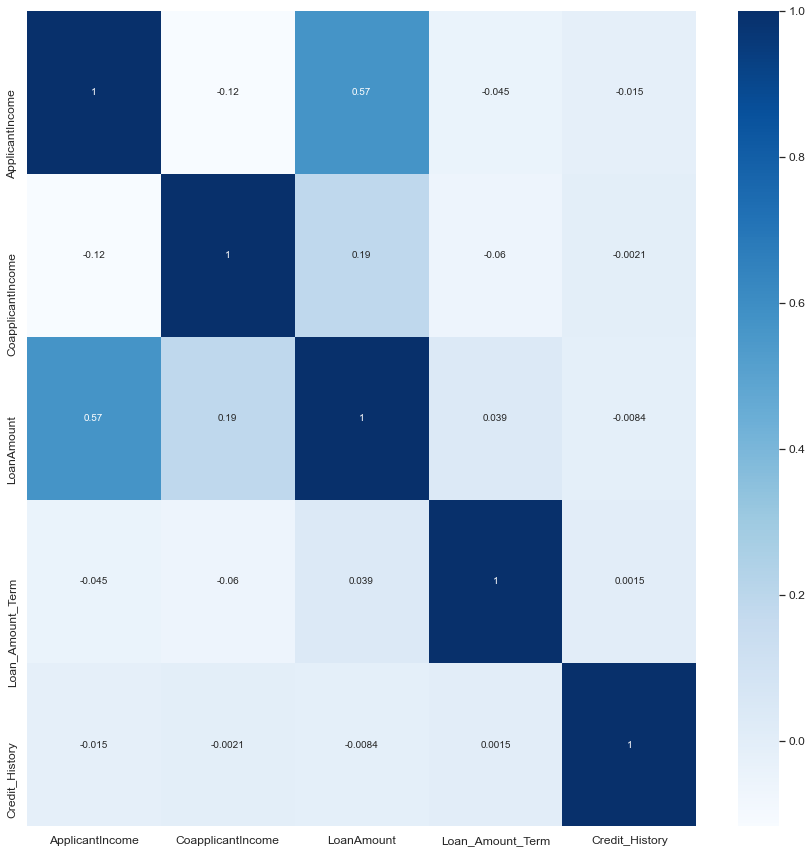

In [93]:
plt.subplots(figsize=(15,15))
data = train.corr()
sns.heatmap(data, cmap ='Blues', annot=True, annot_kws={"size": 10})

In [94]:
def regressor_inputer(df, output_column, input_column, decimals=2):
    
    display(Markdown('**Results:**'))
    #Missing values from Output column
    missing_output = df[output_column].isnull()
    print("Number of missing values in column: {} => {}".format(output_column,missing_output.sum() ))
    
    df_regressor = df.dropna(axis=0, subset = [output_column,input_column])
    df_regressor = df_regressor.loc[:,[output_column,input_column]]
    #Input column observations with Output column missing
    input_column_with_missing_output_column = pd.DataFrame(df[input_column][missing_output])
    input_column_with_missing_output_column = input_column_with_missing_output_column.dropna()
    #Creating regressor model
    x = df_regressor[[input_column]]
    y = df_regressor[[output_column]]
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2)
    lm = LinearRegression().fit(x_train,y_train)
    print(f'R2 value in validation partition: {lm.score(x_val, y_val)}')
    #Predicting output column
    predictor = df[input_column][ df[output_column].isnull()  &  ~df[input_column].isnull() ] 
    predictor = pd.DataFrame(predictor)
    predictor[output_column]=  lm.predict( predictor[[input_column]] ) 
    df.loc[ df[output_column].isnull()  &  ~df[input_column].isnull() ,[output_column]] = predictor[output_column].round(decimals)
    print("New number of missing values in column: {} => {}".format(output_column, df[output_column].isnull().sum() ))
    return df
    #NOT CLEAR ON THIS FUNCTION 

In [95]:
train = regressor_inputer(train,'LoanAmount','ApplicantIncome',0)

**Results:**

Number of missing values in column: LoanAmount => 22
R2 value in validation partition: 0.5161241721631945
New number of missing values in column: LoanAmount => 0


In [96]:
missing_values_table(train)

**Results:**

Your selected dataframe has 12 columns.
There are 6 columns that have missing values.


,Missing Values,% of Total Values
Credit_History,50,8.1
Self_Employed,32,5.2
Dependents,15,2.4
Loan_Amount_Term,14,2.3
Gender,13,2.1
Married,3,0.5


<strong>Let's use mean/mode/median technique to impute missing values for column(s) identified in previous step.</strong>

In [97]:
mean_imputer = SimpleImputer(strategy='mean')
most_frequent_imputer = SimpleImputer(strategy='most_frequent')
median_imputer = SimpleImputer(strategy='median')

In [98]:
train["Credit_History"] = most_frequent_imputer.fit_transform(train[["Credit_History"]])
train["Self_Employed"] = most_frequent_imputer.fit_transform(train[["Self_Employed"]])
train["Dependents"] = most_frequent_imputer.fit_transform(train[["Dependents"]])
train["Loan_Amount_Term"] = most_frequent_imputer.fit_transform(train[["Loan_Amount_Term"]])
train["Gender"] = most_frequent_imputer.fit_transform(train[["Gender"]])
train["Married"] = most_frequent_imputer.fit_transform(train[["Married"]])

<strong>Now, let's check the missingness of the dataset.</strong>

In [99]:
missing_values_table(train)

**Results:**

Your selected dataframe has 12 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


 #### Transforming Columns

<strong>Let's review object columns.</strong>

In [100]:
print("Column data types and their frequency\n{}".format(train.dtypes.value_counts()))

Column data types and their frequency
object     7
float64    4
int64      1
dtype: int64


In [101]:
train.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

In [102]:
def check_object_columns(df):
    object_columns_df = df.select_dtypes(include=['object'])
    print(object_columns_df.iloc[0])
    i=0
    for col in object_columns_df:
        if is_numeric_dtype(df[col]):
            i+=1
            print(f"{col.ljust(25)}" + ' ==> is Numeric')
    if i==0:
        display(Markdown('**Results:**'))
        print('No numeric columns were found')

In [103]:
check_object_columns(train)

Gender               Male
Married                No
Dependents              0
Education        Graduate
Self_Employed          No
Property_Area       Urban
Loan_Status             Y
Name: 0, dtype: object


**Results:**

No numeric columns were found


** Let's convert columns **

In [104]:
def columns_to_numeric(df,columns_to_convert = []):
    display(Markdown('**Results:**'))
    for col in columns_to_convert:
        if col in df.columns:
            if is_numeric_dtype(df[col]):
                df[col] = df[col].str.rstrip('%').astype('float')
                print("Column {} was converted".format(col))
            else:
                print("Column {} could not be converted".format(col))
        else:
            print("Column {} does not exist".format(col))
    return df

In [105]:
train = columns_to_numeric(train,[])
# Not sure why giving error on float columns ==> it only applies to STRING columns with numeric values

**Results:**

<div class="alert alert-block alert-info">
<b><h1>3. Exploratory Data Analysis</h1></div>
</a><a class="anchor" id="exploration"></a>

EDA is the process of performing initial investigations on data so as to:

<li>Uncover underlying structure & patterns in the data
<li>Identify important variables
<li>Identify anomalies
<li>Test a hypothesis
<li>Check assumptions
<li>Set the stage for model development

Exploratory Data Analysis is like listening to what the data can tell us before we start the actual modeling process for a head start. 

** Let's do some data visualization! We'll use seaborn and pandas built-in plotting capabilities.**

Target column is assigned to l_target variable.

In [106]:
l_target = 'Loan_Status'

<div class="alert alert-block alert-warning">
<b>3.1 Univariate Analysis</b>
</div> </a><a class="anchor" id="univariate"></a>

<strong>Let's quick review target column values/distribution.</strong>

In [107]:
list_column_values_percentage(train,15)

**Results:**

Columns with less than 15 values
Male      0.81759
Female    0.18241
Name: Gender, dtype: float64
Yes    0.653094
No     0.346906
Name: Married, dtype: float64
0     0.586319
1     0.166124
2     0.164495
3+    0.083062
Name: Dependents, dtype: float64
Graduate        0.781759
Not Graduate    0.218241
Name: Education, dtype: float64
No     0.86645
Yes    0.13355
Name: Self_Employed, dtype: float64
360.0    0.856678
180.0    0.071661
480.0    0.024430
300.0    0.021173
84.0     0.006515
240.0    0.006515
120.0    0.004886
36.0     0.003257
60.0     0.003257
12.0     0.001629
Name: Loan_Amount_Term, dtype: float64
1.0    0.855049
0.0    0.144951
Name: Credit_History, dtype: float64
Semiurban    0.379479
Urban        0.328990
Rural        0.291531
Name: Property_Area, dtype: float64
Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64


In [108]:
def plot_target_column (df, target):
    ax = sns.countplot(x=target, data=df)
    plt.title('Distribution of ' + target + ' column')
    plt.xlabel('Frequency')
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0)
    total = len(df[target])
    for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height()/total)
            x = p.get_x() + p.get_width() + 0.02
            y = p.get_y() + p.get_height()/2
            ax.annotate(percentage, (x, y))
            ax.text(p.get_x()+p.get_width()/2., p.get_height() + 0.2, p.get_height(),ha="center")
    plt.show()

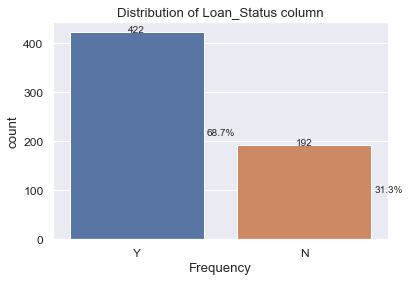

In [109]:
plot_target_column(train, l_target)

** Let's do again a quick review of list of values per each column **

In [110]:
list_column_values(train,15,'True')

**Results:**

Gender                    ==> ['Female', 'Male']
Married                   ==> ['No', 'Yes']
Dependents                ==> ['0', '1', '2', '3+']
Education                 ==> ['Graduate', 'Not Graduate']
Self_Employed             ==> ['No', 'Yes']
ApplicantIncome           ==> more than 15 values
CoapplicantIncome         ==> more than 15 values
LoanAmount                ==> more than 15 values
Loan_Amount_Term          ==> [12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0]
Credit_History            ==> [0.0, 1.0]
Property_Area             ==> ['Rural', 'Semiurban', 'Urban']
Loan_Status               ==> ['N', 'Y']


**Let's plot categorical columns.**

In [111]:
def plot_categorical_columns(df):
    categorical = train.select_dtypes(exclude=['int', 'float']).columns
    lcols_in_plot = 2
    lrows_in_plot = math.ceil(len(categorical)/lcols_in_plot)   
    fig, ax = plt.subplots( lrows_in_plot, lcols_in_plot , figsize=(20, 30))
    plt.subplots_adjust(wspace=0.2, hspace=1) 
    sns.set(font_scale = 1.1)
    for variable, subplot in zip(categorical, ax.flatten()):
        sns.countplot(train[variable], ax=subplot)
        for label in subplot.get_xticklabels():
            label.set_rotation(45)
            label.set_ha("right")
            label.set_rotation_mode("anchor")

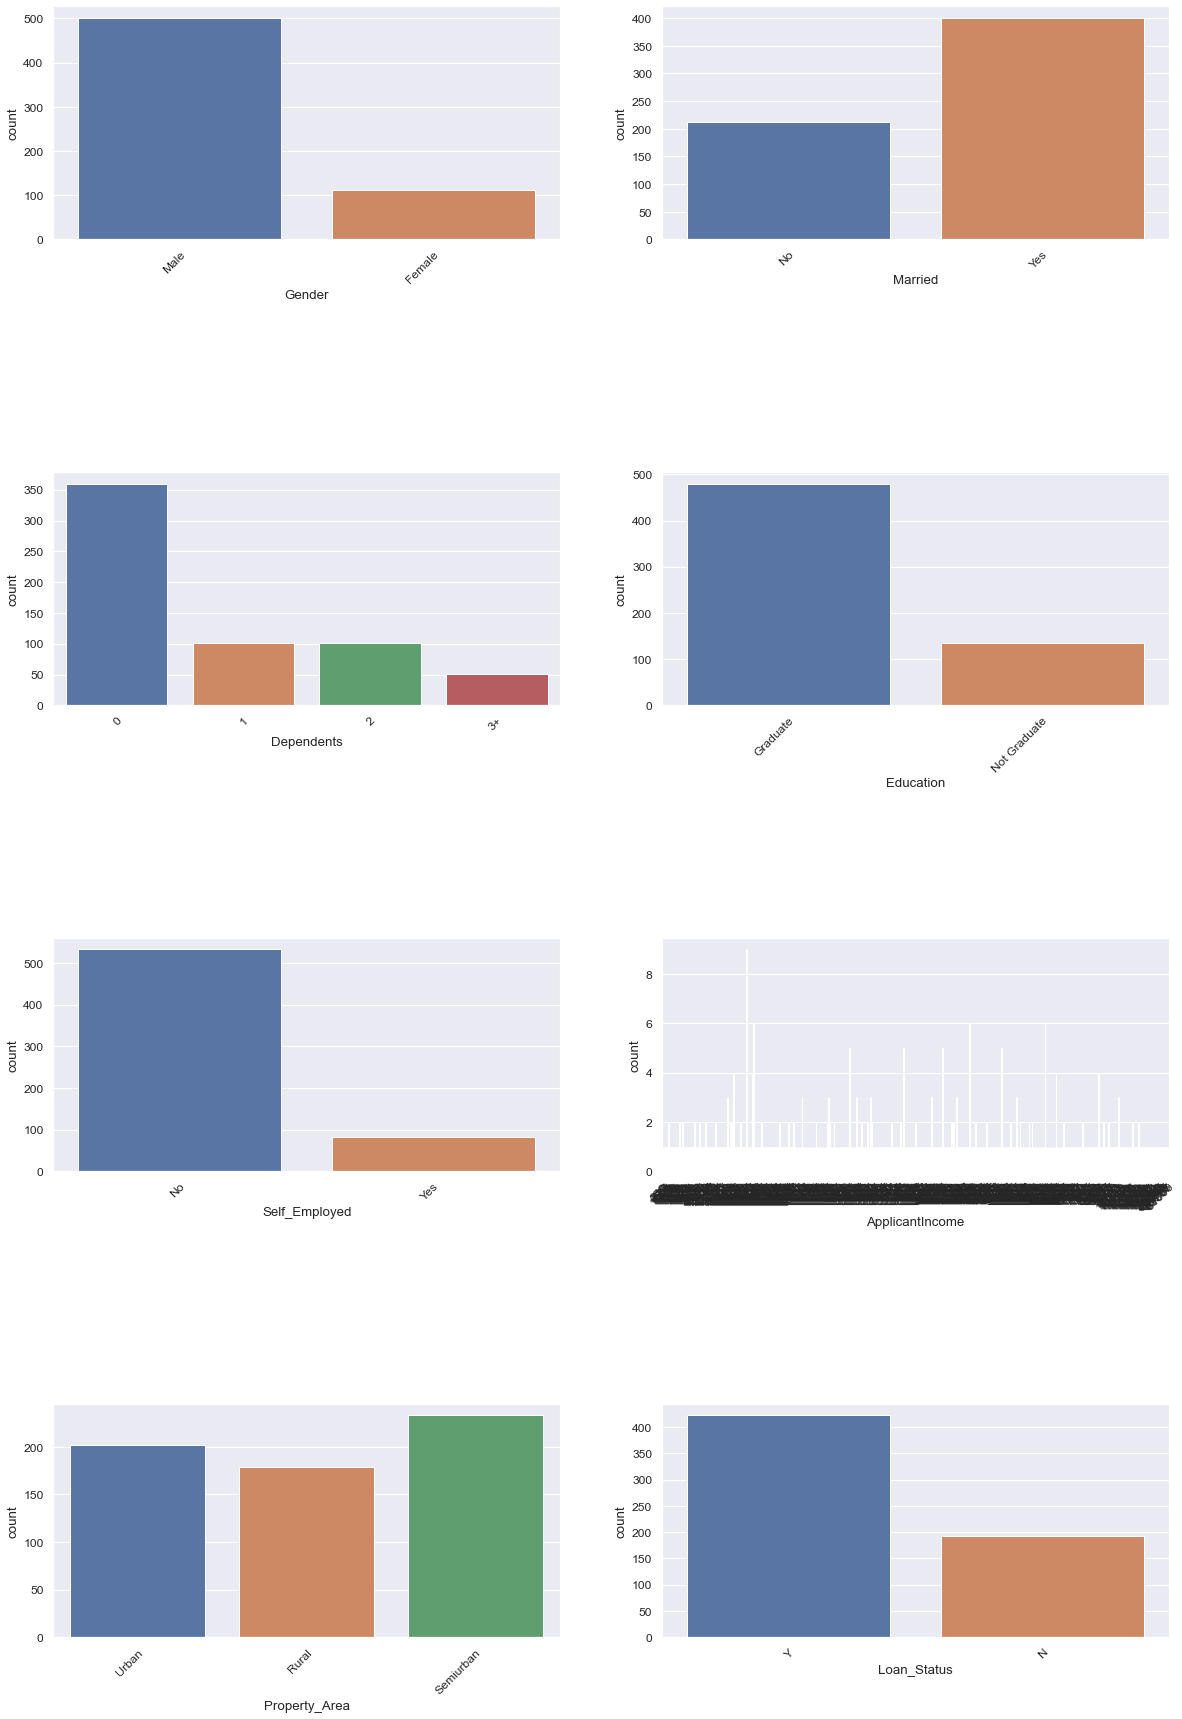

In [112]:
plot_categorical_columns(train)

** Let's plot numerical columns. Using standard and customized function.**

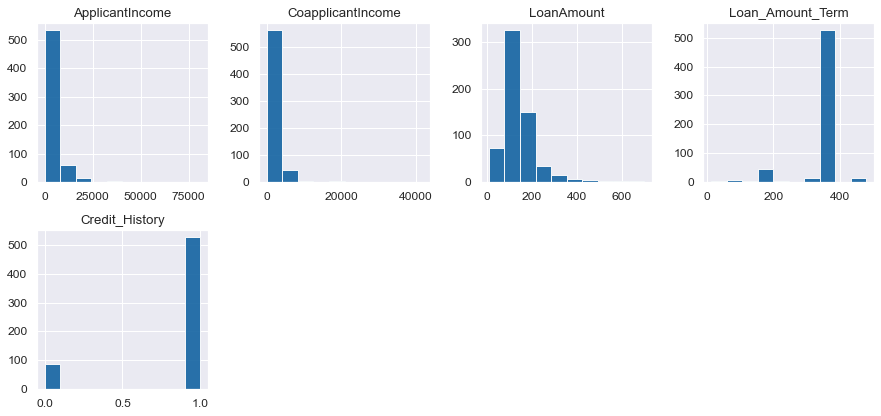

In [113]:
hist = train.hist(figsize = (15, 22), layout=(6, 4) , color='#1363a1',alpha=0.9 )

In [114]:
def plot_numerical_columns(df):
    df = df[df.select_dtypes([np.int64,np.float64]).columns]
    lcols = 2
    lrows = math.ceil(len(df.columns)/lcols)
    plt.figure(figsize=(20,10))
    plt.subplots_adjust(wspace=0.2, hspace=0.5) 
    for i, column in enumerate(df.columns):
        plt.subplot(lrows,lcols,i+1)
        sns.distplot(df[column])

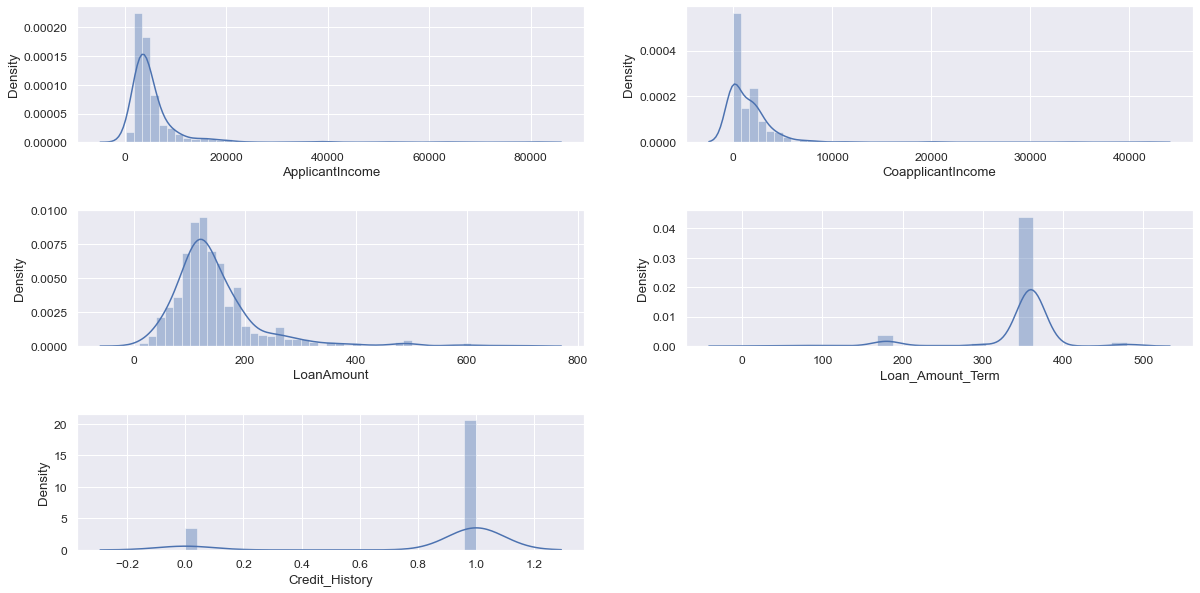

In [115]:
plot_numerical_columns(train)
### Not sure why I get this error

In [116]:
train.select_dtypes(include=object)

,Gender,Married,Dependents,Education,Self_Employed,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,Urban,Y
1,Male,Yes,1,Graduate,No,Rural,N
2,Male,Yes,0,Graduate,Yes,Urban,Y
3,Male,Yes,0,Not Graduate,No,Urban,Y
4,Male,No,0,Graduate,No,Urban,Y
...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,Rural,Y
610,Male,Yes,3+,Graduate,No,Rural,Y
611,Male,Yes,1,Graduate,No,Urban,Y
612,Male,Yes,2,Graduate,No,Urban,Y


In [117]:
train.dtypes

Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object

<div class="alert alert-block alert-warning">
<b>3.2 Bi-variate Analysis</b>
</div> </a><a class="anchor" id="bivariate"></a>

**Let's use crosstab function.**


In [118]:
train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,151.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


In [119]:
col = train.Credit_History
pd.crosstab(train[l_target], [col], margins=True, margins_name="Total", normalize='index')

Credit_History,0.0,1.0
Loan_Status,,
N,0.427083,0.572917
Y,0.016588,0.983412
Total,0.144951,0.855049


In [120]:
col = train.Credit_History
pd.crosstab(train[l_target], [col], margins=True, margins_name="Total")
# These values are using absolute numbers

Credit_History,0.0,1.0,Total
Loan_Status,,,
N,82,110,192
Y,7,415,422
Total,89,525,614


** pairplot() takes a broader view, showing all pairwise relationships and the marginal distributions, optionally conditioned on a categorical variable :**

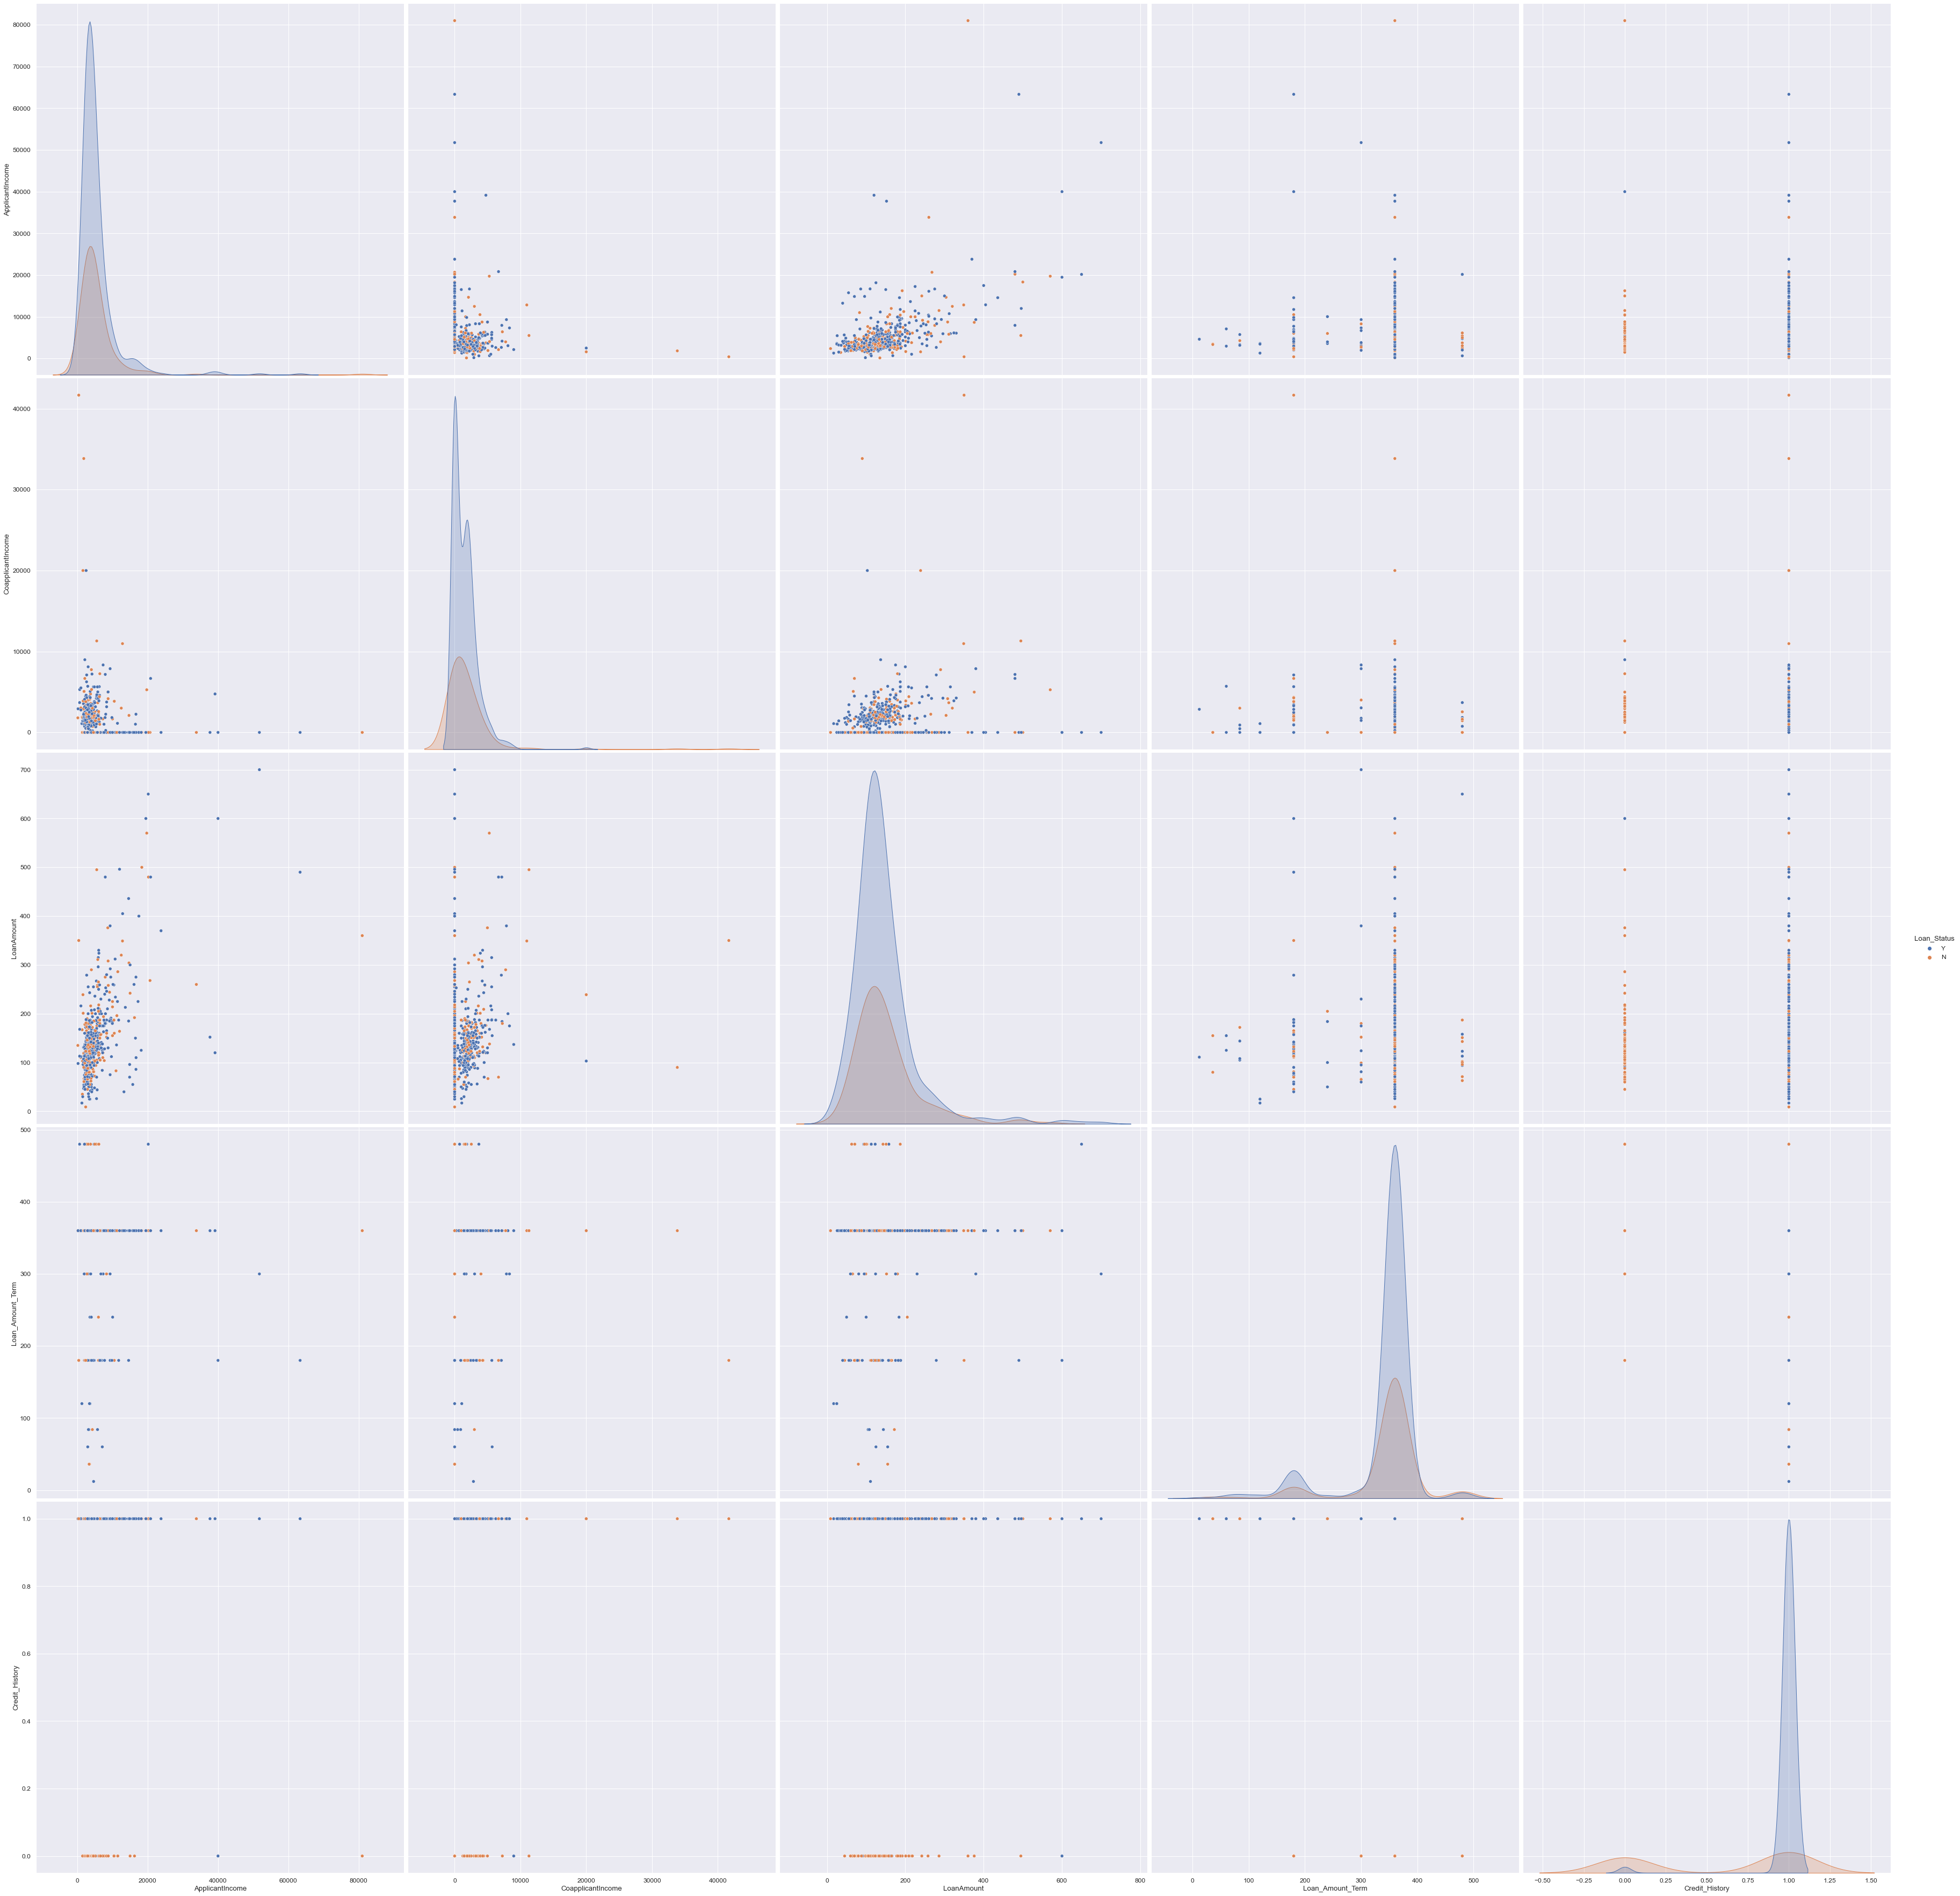

In [121]:
sns.pairplot(data=train, hue=l_target,  height=10);

In [122]:
train

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,151.0,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y
...,...,...,...,...,...,...,...,...,...,...,...,...
609,Female,No,0,Graduate,No,2900,0.0,71.0,360.0,1.0,Rural,Y
610,Male,Yes,3+,Graduate,No,4106,0.0,40.0,180.0,1.0,Rural,Y
611,Male,Yes,1,Graduate,No,8072,240.0,253.0,360.0,1.0,Urban,Y
612,Male,Yes,2,Graduate,No,7583,0.0,187.0,360.0,1.0,Urban,Y


<div class="alert alert-block alert-info">
<b><h1>4. Feature Engineering</h1></div>
</a><a class="anchor" id="engineering"></a>

<strong>Let's move original tables to new ones.</strong>

In [123]:
train1 = train.copy()

In [124]:
print("Column data types and their frequency\n{}".format(train1.dtypes.value_counts()))

Column data types and their frequency
object     7
float64    4
int64      1
dtype: int64


In [125]:
list_column_values(train1,15,'True')

**Results:**

Gender                    ==> ['Female', 'Male']
Married                   ==> ['No', 'Yes']
Dependents                ==> ['0', '1', '2', '3+']
Education                 ==> ['Graduate', 'Not Graduate']
Self_Employed             ==> ['No', 'Yes']
ApplicantIncome           ==> more than 15 values
CoapplicantIncome         ==> more than 15 values
LoanAmount                ==> more than 15 values
Loan_Amount_Term          ==> [12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0]
Credit_History            ==> [0.0, 1.0]
Property_Area             ==> ['Rural', 'Semiurban', 'Urban']
Loan_Status               ==> ['N', 'Y']


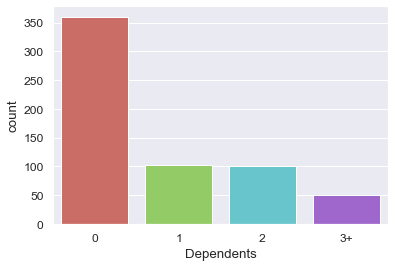

In [126]:
sns.countplot(x='Dependents',data=train1, palette='hls')
plt.show();

<div class="alert alert-block alert-warning">
<b>4.1 General Transformation</b>
</div> </a><a class="anchor" id="general_trans"></a>

<strong>Let's replace categorical values with numerical values.</strong>

In [127]:
#train['education_level'].replace(['Primary School','High School','Graduate','Masters','Phd'],[1,2,3,4,5],inplace=True)

train1['Dependents'].replace(['0', '1', '2', '3+'],[0,1,2,3],inplace=True)


In [128]:
list_column_values(train1,15,'True')

**Results:**

Gender                    ==> ['Female', 'Male']
Married                   ==> ['No', 'Yes']
Dependents                ==> [0, 1, 2, 3]
Education                 ==> ['Graduate', 'Not Graduate']
Self_Employed             ==> ['No', 'Yes']
ApplicantIncome           ==> more than 15 values
CoapplicantIncome         ==> more than 15 values
LoanAmount                ==> more than 15 values
Loan_Amount_Term          ==> [12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0]
Credit_History            ==> [0.0, 1.0]
Property_Area             ==> ['Rural', 'Semiurban', 'Urban']
Loan_Status               ==> ['N', 'Y']


In [129]:

train1['Education'].replace(['Graduate', 'Not Graduate'],[1,2],inplace=True)


In [130]:
train1['Gender'].replace(['Female', 'Male', 'nan'],[1,2,np.nan],inplace=True)

In [131]:
train1['Self_Employed'].replace(['No', 'Yes'],[0,1],inplace=True)

In [132]:
train1['Property_Area'].replace(['Rural', 'Semiurban', 'Urban'],[1, 2, 3],inplace=True)

In [133]:

train1['Married'].replace(['No', 'Yes'],[1,0],inplace=True)

In [134]:
list_column_values(train1,15,'True')

**Results:**

Gender                    ==> [1, 2]
Married                   ==> [0, 1]
Dependents                ==> [0, 1, 2, 3]
Education                 ==> [1, 2]
Self_Employed             ==> [0, 1]
ApplicantIncome           ==> more than 15 values
CoapplicantIncome         ==> more than 15 values
LoanAmount                ==> more than 15 values
Loan_Amount_Term          ==> [12.0, 36.0, 60.0, 84.0, 120.0, 180.0, 240.0, 300.0, 360.0, 480.0]
Credit_History            ==> [0.0, 1.0]
Property_Area             ==> [1, 2, 3]
Loan_Status               ==> ['N', 'Y']


<strong>Let's convert remaining object columns to strings.</strong>

In [135]:
def object_to_str(df, to_str_cols):
    for col in to_str_cols:
        df[col] = df[col].astype(str)
    return df

** I don't have any columns with values left as string. So leaving it as is **

<div class="alert alert-block alert-warning">
<b>4.2 Encoding</b>
</div> </a><a class="anchor" id="encoding"></a>

In [136]:
train1.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,2,1,0,1,0,5849,0.0,151.0,360.0,1.0,3,Y
1,2,0,1,1,0,4583,1508.0,128.0,360.0,1.0,1,N
2,2,0,0,1,1,3000,0.0,66.0,360.0,1.0,3,Y
3,2,0,0,2,0,2583,2358.0,120.0,360.0,1.0,3,Y
4,2,1,0,1,0,6000,0.0,141.0,360.0,1.0,3,Y


In [137]:
print("Column data types and their frequency\n{}".format(train1.dtypes.value_counts()))

Column data types and their frequency
int64      7
float64    4
object     1
dtype: int64


<strong>LABEL ENCODER</strong>

<strong> It Doesn't looks like that I need to use any of the encoding methods</strong>

# SCALING

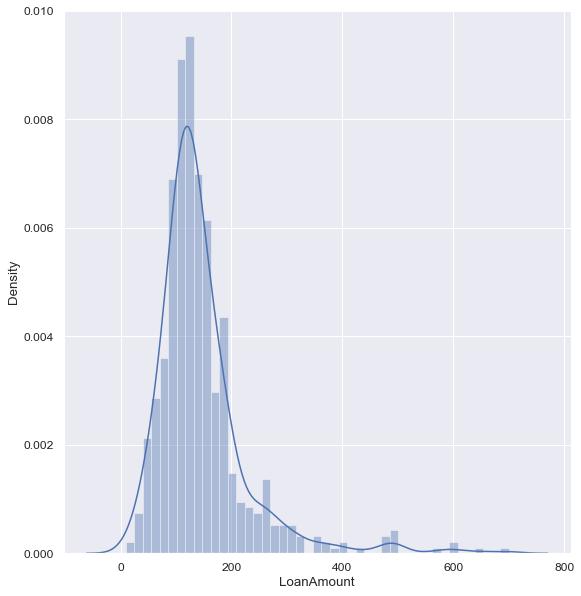

In [138]:
plot_numerical_columns(pd.DataFrame(train1['LoanAmount']))

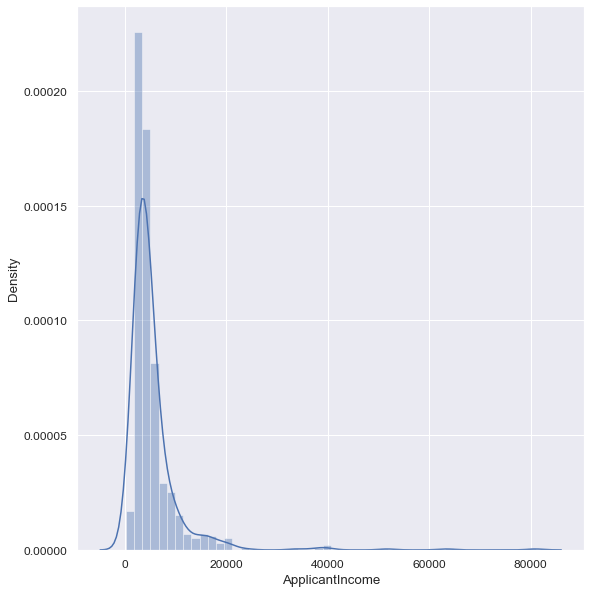

In [139]:
plot_numerical_columns(pd.DataFrame(train1['ApplicantIncome']))

In [140]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train1['LoanAmount'] = pd.DataFrame(scaler.fit_transform(train1[['LoanAmount']]))
train1['ApplicantIncome'] = pd.DataFrame(scaler.fit_transform(train1[['ApplicantIncome']]))


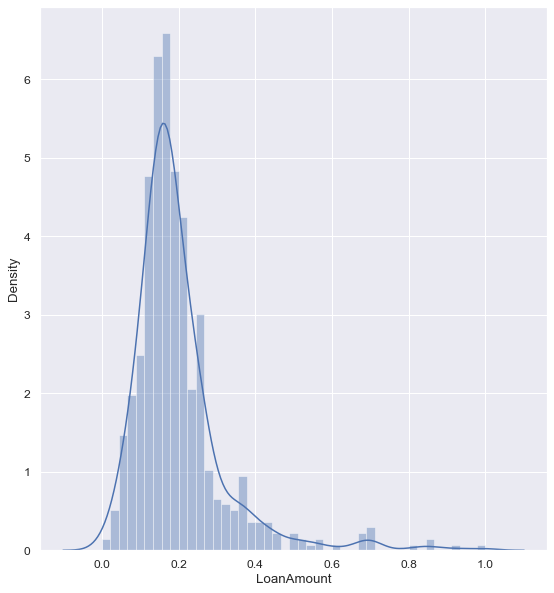

In [141]:
plot_numerical_columns(pd.DataFrame(train1['LoanAmount']))

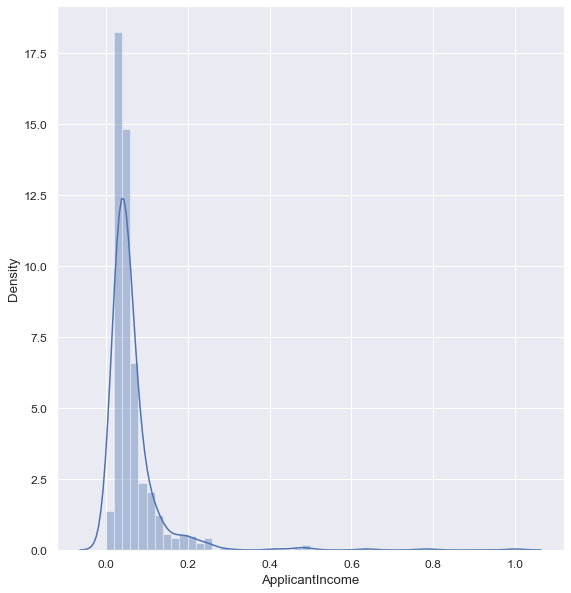

In [142]:
plot_numerical_columns(pd.DataFrame(train1['ApplicantIncome']))

<div class="alert alert-block alert-info">
<b><h1>5. Model Training</h1></div>
<a class="anchor" id="training"></a>

<strong>Let's split the training dataset</strong>

In [143]:
train1['Loan_Status'] = train1['Loan_Status'].map({'Y': 1, 'N': 0})

In [144]:
y = train1[l_target].reset_index(drop=True)
X = train1.drop([l_target], axis=1)

In [145]:
X.shape, y.shape

((614, 11), (614,))

In [146]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import validation_curve
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import log_loss
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
import itertools
import timeit

<div class="alert alert-block alert-warning">
<b>5.1 Decision Tree</b>
</div> </a><a class="anchor" id="encoding"></a>

In [147]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.20, random_state=1, stratify=y)

In [148]:
clf = DecisionTreeClassifier(random_state=0)
clf.fit(X_train,y_train)
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

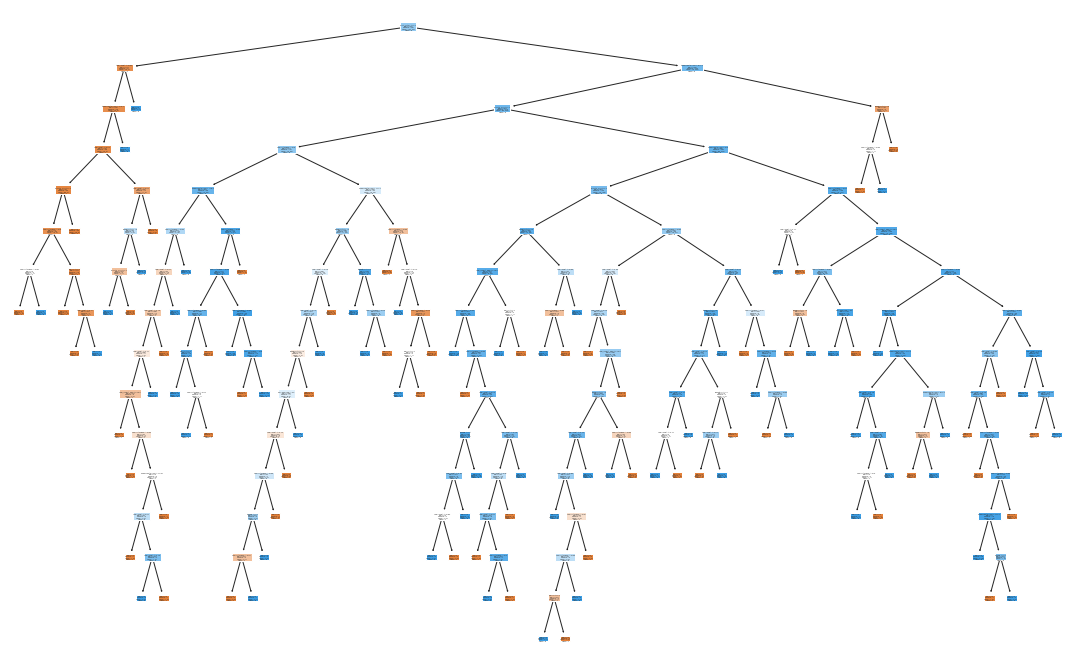

In [149]:
from sklearn.tree import plot_tree
plt.figure(figsize=(19,12))
features = train1.columns
classes = ['Y', 'N']
plot_tree(clf,feature_names=features,class_names=classes,filled=True)
plt.show()

In [150]:
def plot_learning_curve(clf, X, y, title=""):
    
    n = len(y)
    train_mean = []; train_std = [] #model performance score (f1)
    cv_mean = []; cv_std = [] #model performance score (f1)
    fit_mean = []; fit_std = [] #model fit/training time
    pred_mean = []; pred_std = [] #model test/prediction times
    train_sizes=(np.linspace(.05, 1.0, 20)*n).astype('int')  
    
    for i in train_sizes:
        idx = np.random.randint(X.shape[0], size=i)
        X_subset = X[idx,:]
        y_subset = y[idx]
        scores = cross_validate(clf, X_subset, y_subset, cv=10, scoring='f1', n_jobs=-1, return_train_score=True)
        
        train_mean.append(np.mean(scores['train_score'])); train_std.append(np.std(scores['train_score']))
        cv_mean.append(np.mean(scores['test_score'])); cv_std.append(np.std(scores['test_score']))
        fit_mean.append(np.mean(scores['fit_time'])); fit_std.append(np.std(scores['fit_time']))
        pred_mean.append(np.mean(scores['score_time'])); pred_std.append(np.std(scores['score_time']))
    
    train_mean = np.array(train_mean); train_std = np.array(train_std)
    cv_mean = np.array(cv_mean); cv_std = np.array(cv_std)
    fit_mean = np.array(fit_mean); fit_std = np.array(fit_std)
    pred_mean = np.array(pred_mean); pred_std = np.array(pred_std)
    
    plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title)
    plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title)
    
    return train_sizes, train_mean, fit_mean, pred_mean

def plot_LC(train_sizes, train_mean, train_std, cv_mean, cv_std, title):
    
    plt.figure()
    plt.title("Learning Curve: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.fill_between(train_sizes, train_mean - 2*train_std, train_mean + 2*train_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, cv_mean - 2*cv_std, cv_mean + 2*cv_std, alpha=0.1, color="r")
    plt.plot(train_sizes, train_mean, 'o-', color="b", label="Training Score")
    plt.plot(train_sizes, cv_mean, 'o-', color="r", label="Cross-Validation Score")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_times(train_sizes, fit_mean, fit_std, pred_mean, pred_std, title):
    
    plt.figure()
    plt.title("Modeling Time: "+ title)
    plt.xlabel("Training Examples")
    plt.ylabel("Training Time (s)")
    plt.fill_between(train_sizes, fit_mean - 2*fit_std, fit_mean + 2*fit_std, alpha=0.1, color="b")
    plt.fill_between(train_sizes, pred_mean - 2*pred_std, pred_mean + 2*pred_std, alpha=0.1, color="r")
    plt.plot(train_sizes, fit_mean, 'o-', color="b", label="Training Time (s)")
    plt.plot(train_sizes, pred_std, 'o-', color="r", label="Prediction Time (s)")
    plt.legend(loc="best")
    plt.show()
    
    
def plot_confusionmatrix(y_train,y_train_pred,dom):
    print(f'{dom} Confusion Matrix')
    cf = confusion_matrix(y_train,y_train_pred,[1,0])
    
    group_names = ['True Positives','False Positives','False Negatives','True Negatives']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf.flatten()/np.sum(cf)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cf, annot=labels, yticklabels=['Y', 'N'],xticklabels=['Y', 'N'], fmt='', cmap='Blues')
    plt.tight_layout()
    plt.show()
    
def plot_classification_report(y_train,y_train_pred,dom):
    print(f'{dom} Classification Report')
    clf_report = classification_report(y_train,
                                   y_train_pred,
                                   labels=[1,0],
                                   target_names=['Y', 'N'],
                                   output_dict=True)
    sns.heatmap(pd.DataFrame(clf_report).iloc[:-1, :].T, annot=True , cmap='Blues')
    plt.tight_layout()
    plt.show()    
    
def final_classifier_evaluation(clf,X_train, X_test, y_train, y_test, title):
    
    start_time = timeit.default_timer()
    clf.fit(X_train, y_train)
    end_time = timeit.default_timer()
    training_time = end_time - start_time
    
    start_time = timeit.default_timer()    
    y_pred = clf.predict(X_test)
    end_time = timeit.default_timer()
    pred_time = end_time - start_time
    
    auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test,y_pred)
    accuracy = accuracy_score(y_test,y_pred)
    precision = precision_score(y_test,y_pred)
    recall = recall_score(y_test,y_pred)

    plot_confusionmatrix(y_test,y_pred,dom=title)

    plot_classification_report(y_test,y_pred,dom=title)

In [151]:
from sklearn.tree import DecisionTreeClassifier

def hyperTree(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    max_depth = list(range(1,31))
    for i in max_depth:         
            clf = DecisionTreeClassifier(max_depth=i, random_state=100, min_samples_leaf=1, criterion='entropy')
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(max_depth, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(max_depth, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Max Tree Depth')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
     
    
def TreeGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    #parameters to search:
    #20 values of min_samples leaf from 0.5% sample to 5% of the training data
    #20 values of max_depth from 1, 20
    param_grid = {'min_samples_leaf':np.linspace(start_leaf_n,end_leaf_n,20).round().astype('int'), 'max_depth':np.arange(3,20)}

    tree = GridSearchCV(estimator = DecisionTreeClassifier(), param_grid=param_grid, cv=5)
    tree.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(tree.best_params_)
    return tree.best_params_['max_depth'], tree.best_params_['min_samples_leaf']

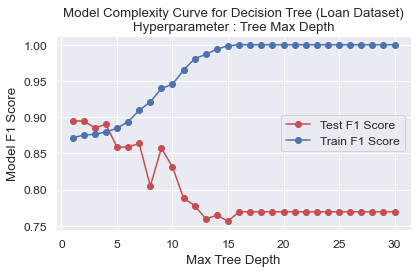

Per Hyperparameter tuning, best parameters are:
{'max_depth': 3, 'min_samples_leaf': 25}


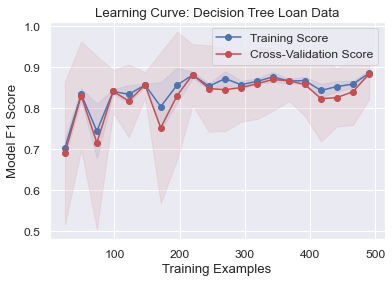

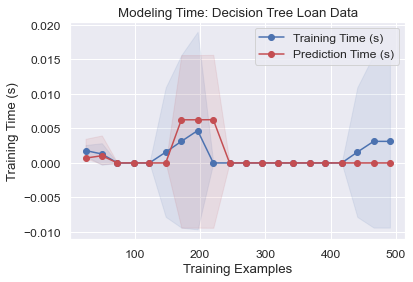

Test - Unseen Data Confusion Matrix


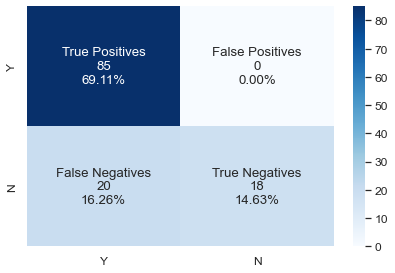

Test - Unseen Data Classification Report


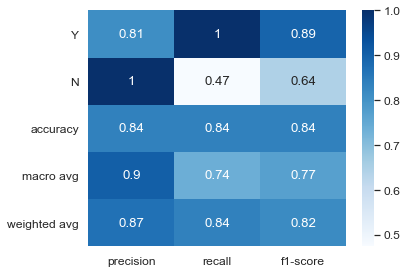

In [152]:
X_train, X_test, y_train, y_test  = train_test_split(np.array(X),np.array(y), test_size=0.20, random_state=1, stratify=y)

hyperTree(X_train, y_train, X_test, y_test,title="Model Complexity Curve for Decision Tree (Loan Dataset)\nHyperparameter : Tree Max Depth")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) #leaf nodes of size [0.5%, 5% will be tested]
max_depth, min_samples_leaf = TreeGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
estimator_loan = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=100, criterion='entropy')

train_samp_loan, DT_train_score_loan, DT_fit_time_loan, DT_pred_time_loan = plot_learning_curve(estimator_loan, X_train, y_train,title="Decision Tree Loan Data")

final_classifier_evaluation(estimator_loan, X_train, X_test, y_train, y_test, 'Test - Unseen Data')

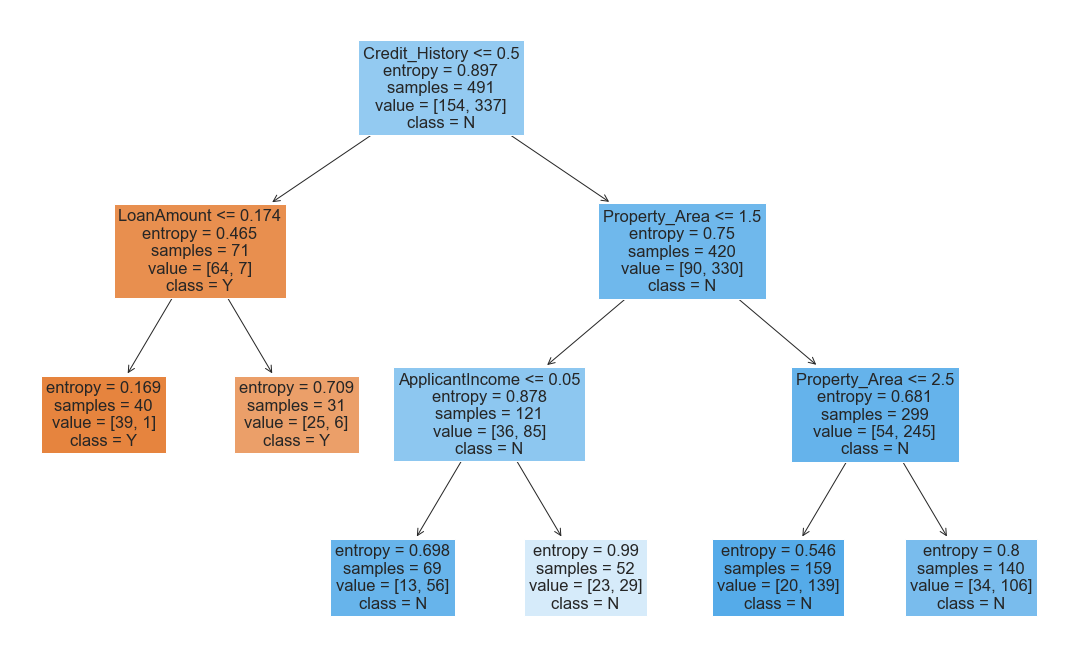

In [153]:
from sklearn.tree import plot_tree
plt.figure(figsize=(19,12))
features = train1.columns
classes = ['Y', 'N']
plot_tree(estimator_loan,feature_names=features,class_names=classes,filled=True)
plt.show()

<div class="alert alert-block alert-warning">
<b>5.2 Neural Network</b>
</div> </a><a class="anchor" id="encoding"></a>

In [154]:
from sklearn.neural_network import MLPClassifier

def hyperNN(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    lrlist = [ 0.005, 0.01,0.05,0.1,0.5]
    for lr in lrlist:         
            clf = MLPClassifier(hidden_layer_sizes=(5,5), solver='adam', activation='relu', 
                                learning_rate_init=lr, random_state=100)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(lrlist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(lrlist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Learning Rate')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
    
def NNGridSearchCV(X_train, y_train):
    #parameters to search:
    #number of hidden units
    #learning_rate
    h_units = [5, 10, 20, 30, 40, 50, 75, 100]
    lrlist = [0.01,0.05,0.1,0.5]
    h_units = [(12, 24), (10, 20, 10), (5,5),(8)]
    f_activation=[ 'tanh', 'relu']
    
        
        
    param_grid = {'hidden_layer_sizes': h_units, 'learning_rate_init': lrlist, 'activation': f_activation}

    net = GridSearchCV(estimator = MLPClassifier(solver='adam',random_state=100),
                       param_grid=param_grid, cv=5)
    net.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(net.best_params_)
    return net.best_params_['hidden_layer_sizes'], net.best_params_['learning_rate_init'], net.best_params_['activation']

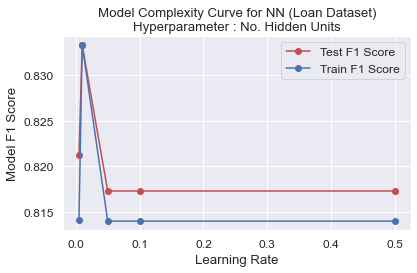

Per Hyperparameter tuning, best parameters are:
{'activation': 'tanh', 'hidden_layer_sizes': 8, 'learning_rate_init': 0.01}


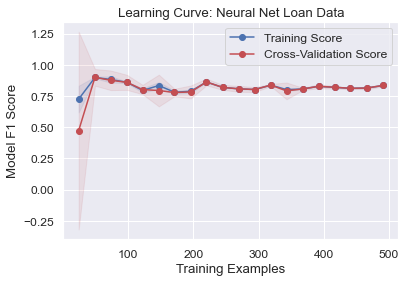

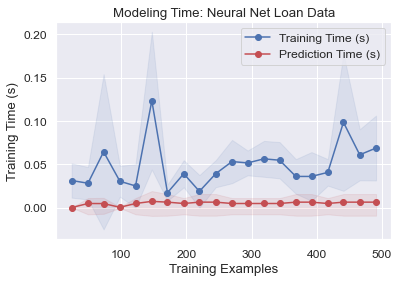

Test - Unseen Data Confusion Matrix


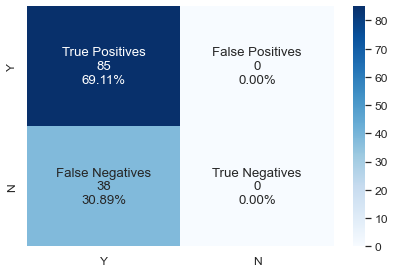

Test - Unseen Data Classification Report


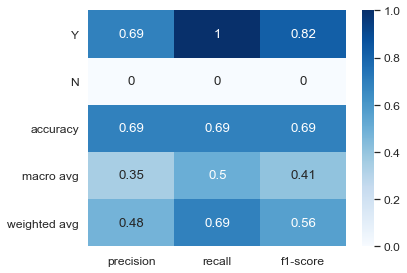

In [155]:
X_train, X_test, y_train, y_test  = train_test_split(np.array(X),np.array(y), test_size=0.20, random_state=1, stratify=y)

hyperNN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for NN (Loan Dataset)\nHyperparameter : No. Hidden Units")
h_units, learn_rate, f_activation = NNGridSearchCV(X_train, y_train)
estimator_loan = MLPClassifier(hidden_layer_sizes=h_units, solver='adam', activation=f_activation, 
                               learning_rate_init=learn_rate, random_state=1)
train_samp_loan, NN_train_score_loan, NN_fit_time_loan, NN_pred_time_loan = plot_learning_curve(estimator_loan, X_train, y_train,title="Neural Net Loan Data")
final_classifier_evaluation(estimator_loan, X_train, X_test, y_train, y_test ,'Test - Unseen Data')


<div class="alert alert-block alert-warning">
<b>5.3 Boosting Decision Tree</b>
</div> </a><a class="anchor" id="encoding"></a>

In [156]:
from sklearn.ensemble import GradientBoostingClassifier

def hyperBoost(X_train, y_train, X_test, y_test, max_depth, min_samples_leaf, title):
    
    f1_test = []
    f1_train = []
    n_estimators = np.linspace(1,250,40).astype('int')
    for i in n_estimators:         
            clf = GradientBoostingClassifier(n_estimators=i, max_depth=int(max_depth/2), 
                                             min_samples_leaf=int(min_samples_leaf/2), random_state=100,)
            clf.fit(X_train, y_train)
            y_pred_test = clf.predict(X_test)
            y_pred_train = clf.predict(X_train)
            f1_test.append(f1_score(y_test, y_pred_test))
            f1_train.append(f1_score(y_train, y_pred_train))
      
    plt.plot(n_estimators, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(n_estimators, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Estimators')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()

def BoostedGridSearchCV(start_leaf_n, end_leaf_n, X_train, y_train):
    param_grid = {'min_samples_leaf': np.linspace(start_leaf_n,end_leaf_n,3).round().astype('int'),
                  'max_depth': np.arange(3,8),
                  'n_estimators': np.linspace(10,100,3).round().astype('int'),
                  'learning_rate': np.linspace(.001,.1,3)}

    boost = GridSearchCV(estimator = GradientBoostingClassifier(), param_grid=param_grid, cv=5)
    boost.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(boost.best_params_)
    return boost.best_params_['max_depth'], boost.best_params_['min_samples_leaf'], boost.best_params_['n_estimators'], boost.best_params_['learning_rate']


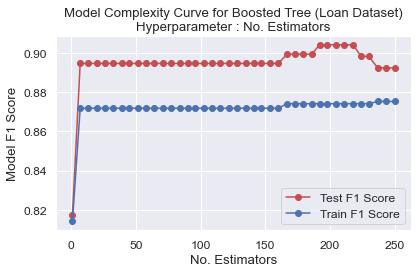

Per Hyperparameter tuning, best parameters are:
{'learning_rate': 0.0505, 'max_depth': 5, 'min_samples_leaf': 25, 'n_estimators': 55}


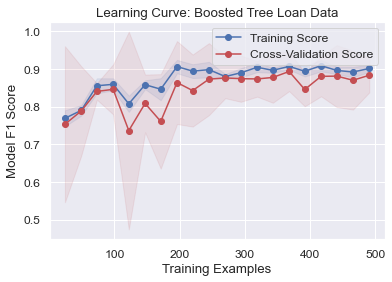

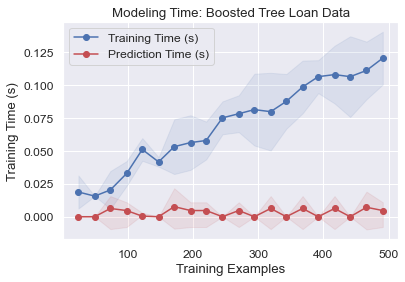

Test - Unseen Data Confusion Matrix


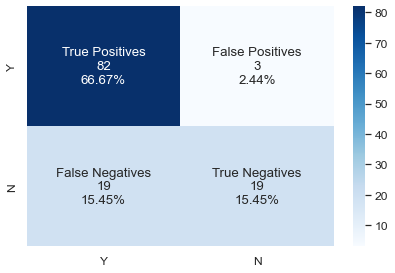

Test - Unseen Data Classification Report


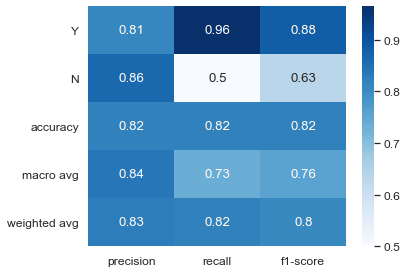

In [157]:
X_train, X_test, y_train, y_test  = train_test_split(np.array(X),np.array(y), test_size=0.20, random_state=1, stratify=y)


hyperBoost(X_train, y_train, X_test, y_test, 3, 50, title="Model Complexity Curve for Boosted Tree (Loan Dataset)\nHyperparameter : No. Estimators")
start_leaf_n = round(0.005*len(X_train))
end_leaf_n = round(0.05*len(X_train)) 
max_depth, min_samples_leaf, n_est, learn_rate = BoostedGridSearchCV(start_leaf_n,end_leaf_n,X_train,y_train)
estimator_loan = GradientBoostingClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                              n_estimators=n_est, learning_rate=learn_rate, random_state=100)
train_samp_loan, BT_train_score_loan, BT_fit_time_loan, BT_pred_time_loan = plot_learning_curve(estimator_loan, X_train, y_train,title="Boosted Tree Loan Data")
final_classifier_evaluation(estimator_loan, X_train, X_test, y_train, y_test ,'Test - Unseen Data')


<div class="alert alert-block alert-warning">
<b>5.4 Support Vector Machine</b>
</div> </a><a class="anchor" id="encoding"></a>

In [158]:
from sklearn.svm import SVC

def hyperSVM(X_train, y_train, X_test, y_test, title):

    f1_test = []
    f1_train = []
    kernel_func = ['linear','poly','rbf']
    for i in kernel_func:         
            if i == 'poly':
                for j in [2,3]:
                    clf = SVC(kernel=i, degree=j,random_state=100)
                    clf.fit(X_train, y_train)
                    y_pred_test = clf.predict(X_test)
                    y_pred_train = clf.predict(X_train)
                    f1_test.append(f1_score(y_test, y_pred_test))
                    f1_train.append(f1_score(y_train, y_pred_train))
            else:    
                clf = SVC(kernel=i, random_state=100)
                clf.fit(X_train, y_train)
                y_pred_test = clf.predict(X_test)
                y_pred_train = clf.predict(X_train)
                f1_test.append(f1_score(y_test, y_pred_test))
                f1_train.append(f1_score(y_train, y_pred_train))
                
    xvals = ['linear','poly2','poly3','rbf']
    plt.plot(xvals, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(xvals, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('Kernel Function')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    
def SVMGridSearchCV(X_train, y_train):
    #parameters to search:
    #penalty parameter, C
    #
    Cs = [1,0.05,0.1,0.5]
    kernels = ['poly','rbf']
    param_grid = {'C': Cs,  'kernel': kernels}
    
    clf = GridSearchCV(estimator = SVC(random_state=100),
                       param_grid=param_grid, cv=5)
    clf.fit(X_train, y_train)
    print("Per Hyperparameter tuning, best parameters are:")
    print(clf.best_params_)
    return clf.best_params_['C'], clf.best_params_['kernel']

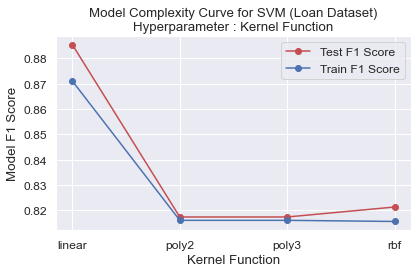

Per Hyperparameter tuning, best parameters are:
{'C': 0.05, 'kernel': 'rbf'}


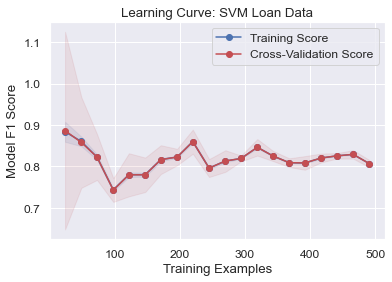

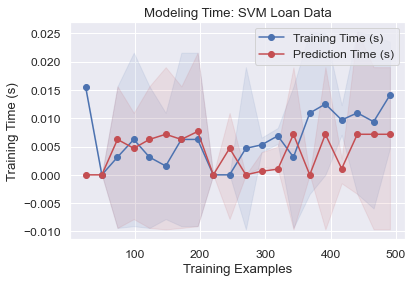

Test - Unseen Data Confusion Matrix


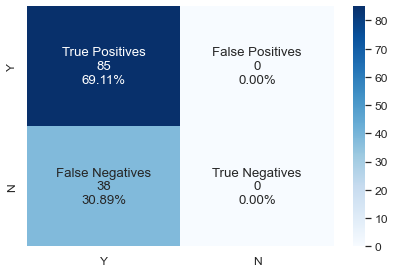

Test - Unseen Data Classification Report


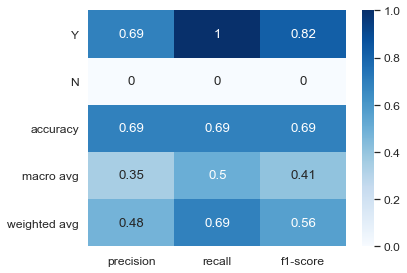

Wall time: 1min 20s


In [160]:
%%time

X_train, X_test, y_train, y_test  = train_test_split(np.array(X),np.array(y), test_size=0.20, random_state=1, stratify=y)

hyperSVM(X_train, y_train, X_test, y_test,title="Model Complexity Curve for SVM (Loan Dataset)\nHyperparameter : Kernel Function")

C_val, kernel_val= SVMGridSearchCV(X_train, y_train)

estimator_loan = SVC(C=C_val, kernel=kernel_val,random_state=100)
train_samp_loan, SVM_train_score_loan, SVM_fit_time_loan, SVM_pred_time_loan = plot_learning_curve(estimator_loan, X_train, y_train,title="SVM Loan Data")
final_classifier_evaluation(estimator_loan, X_train, X_test, y_train, y_test,'Test - Unseen Data')

<div class="alert alert-block alert-warning">
<b>5.5 K-nearest neighbors</b>
</div> </a><a class="anchor" id="encoding"></a>

In [161]:
from sklearn.neighbors import KNeighborsClassifier as kNN

def hyperKNN(X_train, y_train, X_test, y_test, title):
    
    f1_test = []
    f1_train = []
    klist = np.linspace(1,250,25).astype('int')
    for i in klist:
        clf = kNN(n_neighbors=i,n_jobs=-1)
        clf.fit(X_train,y_train)
        y_pred_test = clf.predict(X_test)
        y_pred_train = clf.predict(X_train)
        f1_test.append(f1_score(y_test, y_pred_test))
        f1_train.append(f1_score(y_train, y_pred_train))
        
    plt.plot(klist, f1_test, 'o-', color='r', label='Test F1 Score')
    plt.plot(klist, f1_train, 'o-', color = 'b', label='Train F1 Score')
    plt.ylabel('Model F1 Score')
    plt.xlabel('No. Neighbors')
    
    plt.title(title)
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()
    

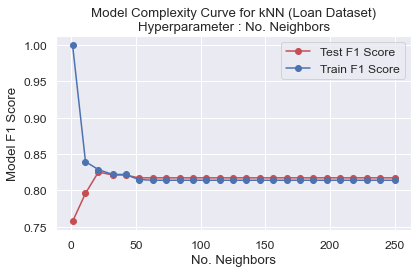

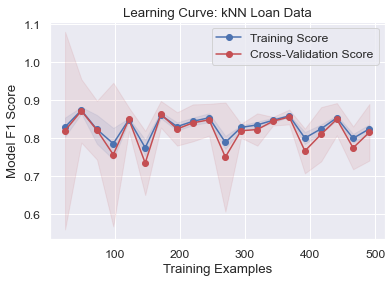

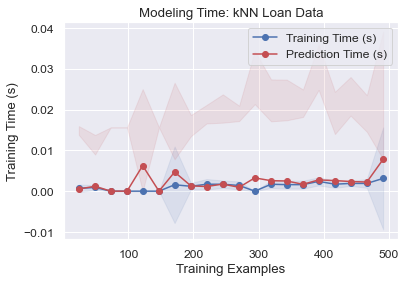

Test - Unseen Data Confusion Matrix


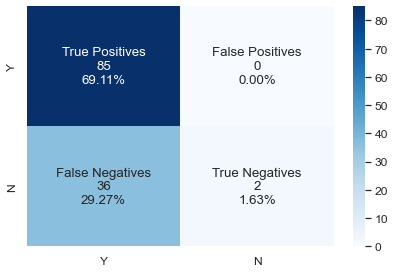

Test - Unseen Data Classification Report


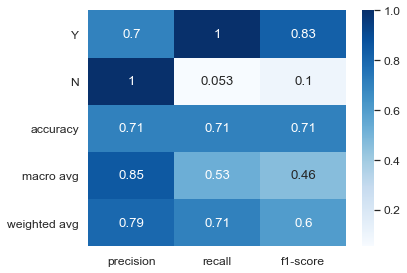

In [162]:
X_train, X_test, y_train, y_test  = train_test_split(np.array(X),np.array(y), test_size=0.20, random_state=1, stratify=y)

hyperKNN(X_train, y_train, X_test, y_test,title="Model Complexity Curve for kNN (Loan Dataset)\nHyperparameter : No. Neighbors")
estimator_loan = kNN(n_neighbors=20, n_jobs=-1)
train_samp_loan, kNN_train_score_loan, kNN_fit_time_loan, kNN_pred_time_loan = plot_learning_curve(estimator_loan, X_train, y_train,title="kNN Loan Data")
final_classifier_evaluation(estimator_loan, X_train, X_test, y_train, y_test,'Test - Unseen Data')

<div class="alert alert-block alert-warning">
<b>5.6 Compare and contrast the different algorithms</b>
</div> </a><a class="anchor" id="encoding"></a>

In [163]:
def compare_fit_time(n,NNtime, SMVtime, kNNtime, DTtime, BTtime, title):
    
    plt.figure()
    plt.title("Model Training Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Training Time (s)")
    plt.plot(n, NNtime, '-', color="b", label="Neural Network")
    plt.plot(n, SMVtime, '-', color="r", label="SVM")
    plt.plot(n, kNNtime, '-', color="g", label="kNN")
    plt.plot(n, DTtime, '-', color="m", label="Decision Tree")
    plt.plot(n, BTtime, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()
    
def compare_pred_time(n,NNpred, SMVpred, kNNpred, DTpred, BTpred, title):
    
    plt.figure()
    plt.title("Model Prediction Times: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model Prediction Time (s)")
    plt.plot(n, NNpred, '-', color="b", label="Neural Network")
    plt.plot(n, SMVpred, '-', color="r", label="SVM")
    plt.plot(n, kNNpred, '-', color="g", label="kNN")
    plt.plot(n, DTpred, '-', color="m", label="Decision Tree")
    plt.plot(n, BTpred, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show()


def compare_learn_time(n,NNlearn, SMVlearn, kNNlearn, DTlearn, BTlearn, title):
    
    plt.figure()
    plt.title("Model Learning Rates: " + title)
    plt.xlabel("Training Examples")
    plt.ylabel("Model F1 Score")
    plt.plot(n, NNlearn, '-', color="b", label="Neural Network")
    plt.plot(n, SMVlearn, '-', color="r", label="SVM")
    plt.plot(n, kNNlearn, '-', color="g", label="kNN")
    plt.plot(n, DTlearn, '-', color="m", label="Decision Tree")
    plt.plot(n, BTlearn, '-', color="k", label="Boosted Tree")
    plt.legend(loc="best")
    plt.show() 

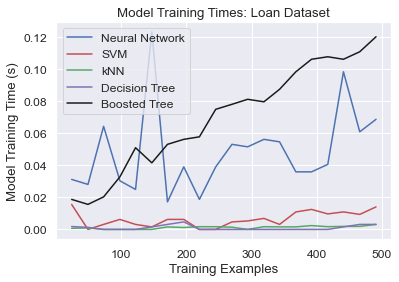

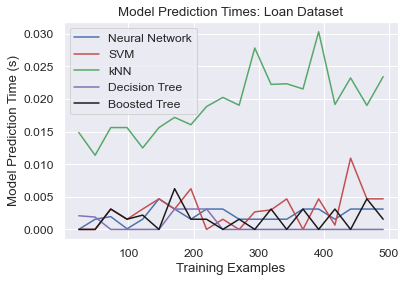

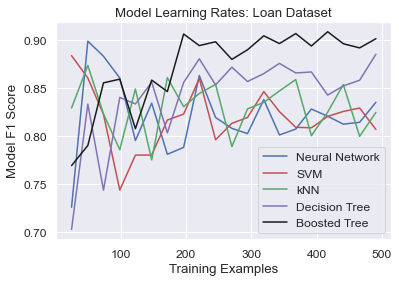

In [164]:
compare_fit_time(train_samp_loan, NN_fit_time_loan, SVM_fit_time_loan, kNN_fit_time_loan, 
                 DT_fit_time_loan, BT_fit_time_loan, 'Loan Dataset')              
compare_pred_time(train_samp_loan, NN_pred_time_loan, SVM_pred_time_loan, kNN_pred_time_loan, 
                 DT_pred_time_loan, BT_pred_time_loan, 'Loan Dataset')   
compare_learn_time(train_samp_loan, NN_train_score_loan, SVM_train_score_loan, kNN_train_score_loan, 
                 DT_train_score_loan, BT_train_score_loan, 'Loan Dataset')  
